# World Wide Products - Time Series Forecasting

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style = "whitegrid")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from fbprophet import Prophet


%matplotlib inline

In [206]:
# Read input dataset
df = pd.read_csv("Historical_Product_demand.csv")

# EDA

In [3]:
df.columns

Index([u'Product_Code', u'Warehouse', u'Product_Category', u'Date',
       u'Order_Demand'],
      dtype='object')

In [4]:
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [5]:
df.shape

(1048575, 5)

In [7]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [8]:
#Dropping the null values from the Date column
df.dropna(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 0 to 1048574
Data columns (total 5 columns):
Product_Code        1037336 non-null object
Warehouse           1037336 non-null object
Product_Category    1037336 non-null object
Date                1037336 non-null object
Order_Demand        1037336 non-null object
dtypes: object(5)
memory usage: 47.5+ MB


In [10]:
df.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1037336,1037336,1037336,1037336,1037336
unique,2160,4,33,1729,3749
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,470266,2075,112263


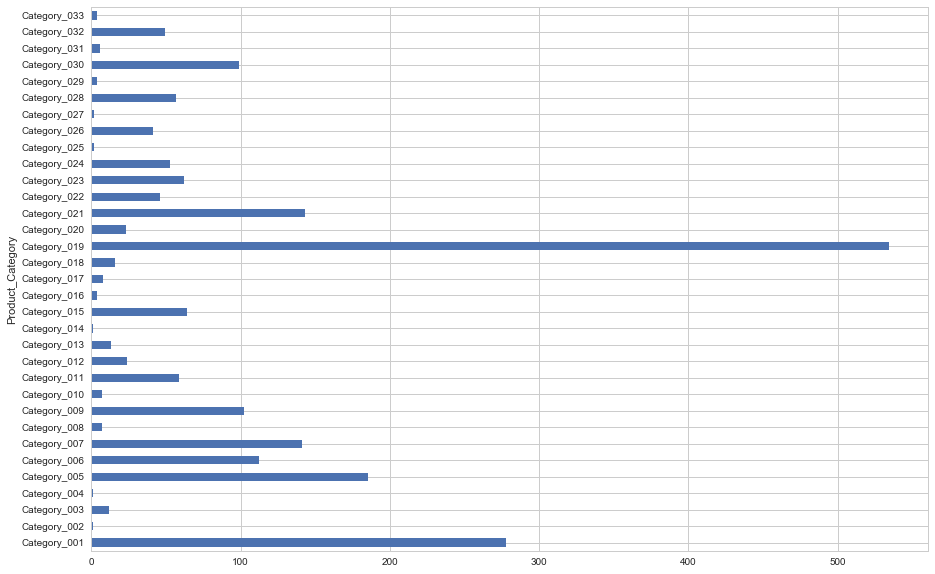

In [22]:
#Plotting the number of products per category

df.groupby('Product_Category')['Product_Code'].nunique().plot(kind='barh',
                                    figsize=(15,10))

Text(0,0.5,'Product')

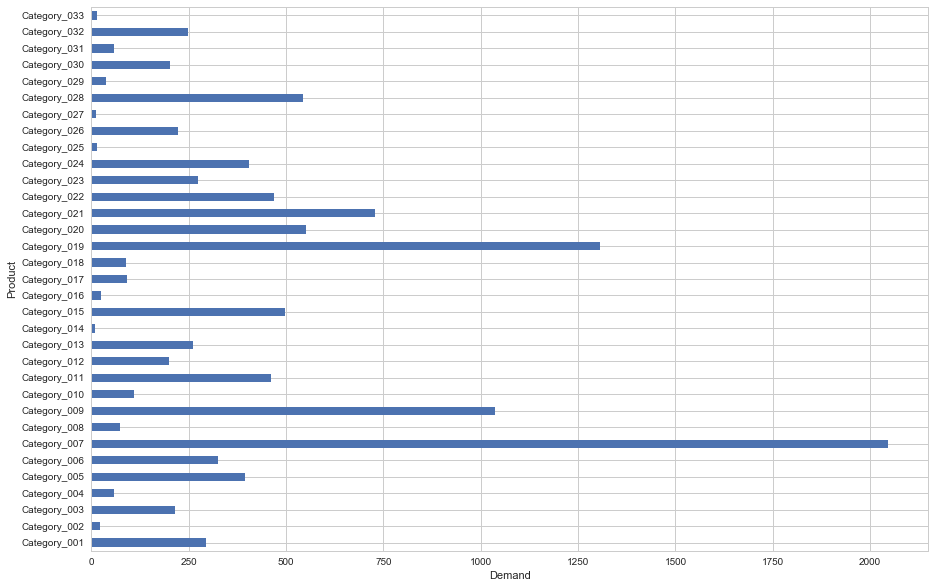

In [29]:
#Plotting the prodcuts based on their Demand
ax = df.groupby('Product_Category')['Order_Demand'].nunique().plot(kind='barh',figsize=(15,10))
ax.set_xlabel("Demand")
ax.set_ylabel("Product")

In [ ]:
# num_of_prod = df.groupby(['Product_Code']).size().reset_index(name='counts').sort_values(['counts'],ascending=False)
num_of_prod.head(10)

Since the product with product code 1359 has the highest count, let us focus of predicting the demand for this product in the following steps..

# Feature Engineering 

In [88]:
#Creating a new dataframe with only the details of product 1359
df_1359 = df.loc[df['Product_Code'] == 'Product_1359'].sort_values(['Date'],ascending=False)

In [89]:
df_1359.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
921328,Product_1359,Whse_J,Category_019,2017/1/6,100000
863636,Product_1359,Whse_J,Category_019,2016/9/9,9000
893829,Product_1359,Whse_J,Category_019,2016/9/9,40000
1013066,Product_1359,Whse_J,Category_019,2016/9/9,2000
863593,Product_1359,Whse_J,Category_019,2016/9/9,1000


In [90]:
df_1359.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,16936,16936,16936,16936,16936
unique,1,1,1,1232,161
top,Product_1359,Whse_J,Category_019,2013/1/7,1000
freq,16936,16936,16936,35,2578


Since there is only one unique value for Product code, Warehouse and Product category, they provide no additional value for our analysis. We can delete these columns, and retain only the date and demand columns, which are essential for our time series analysis 

In [91]:
df_1359 = df_1359.drop(['Product_Code','Warehouse','Product_Category'],axis=1)
df_1359.reset_index(drop=True, inplace=True)

In [92]:
#Converting date into datetimeindex format
df_1359.loc[:,'Date'] = pd.to_datetime(df_1359.loc[:,'Date'], format="%Y/%m/%d")

In [93]:
#Setting the index to date values
df_1359 = df_1359.set_index('Date')

In [94]:
df_1359['Order_Demand'] = df_1359['Order_Demand'].astype(str)
df_1359['Order_Demand'] = df_1359['Order_Demand'].map(lambda x: x.lstrip('(').rstrip(')'))
df_1359['Order_Demand'] = df_1359['Order_Demand'].astype(int)

In [95]:
#Grouping the dates by month 
df_1359M = df_1359.resample('M').sum()
df_1359M.head(10)

,Order_Demand
Date,
2012-01-31,8911000
2012-02-29,8131000
2012-03-31,7775000
2012-04-30,8960000
2012-05-31,8475000
2012-06-30,6556000
2012-07-31,7422000
2012-08-31,6667000
2012-09-30,8349000


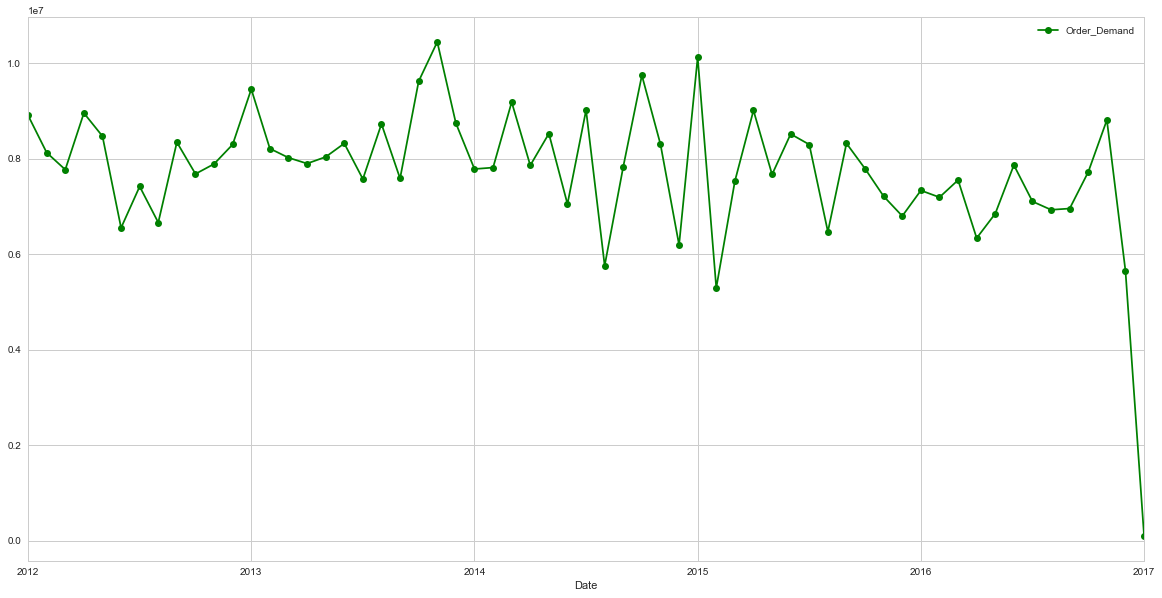

In [106]:
#Plotting time series for this product
df_1359M.plot(figsize=(20,10),color='green',marker='o')
plt.show()

# Time Series Forecasting

In [119]:
df_1359M.index

DatetimeIndex(['2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
               '2012-09-30', '2012-10-31', '2012-11-30', '2012-12-31',
               '2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
      

In [160]:
#Converting the date and demand columns to be suitable for our forecasting model using FB prophet
fin_df = df_1359M
fin_df = fin_df.rename(columns={ 'Order_Demand': "y" })
fin_df.reset_index(level=0, inplace=True)
fin_df = fin_df.rename(columns={ 'Date': "ds" })

In [161]:
fin_df.head()

,ds,y
0,2012-01-31,8911000
1,2012-02-29,8131000
2,2012-03-31,7775000
3,2012-04-30,8960000
4,2012-05-31,8475000


In [201]:
model = Prophet()
model.fit(fin_df)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [202]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
421,2018-01-27
422,2018-01-28
423,2018-01-29
424,2018-01-30
425,2018-01-31


In [203]:
#predicting the future model
forecast = m.predict(future)
forecast_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

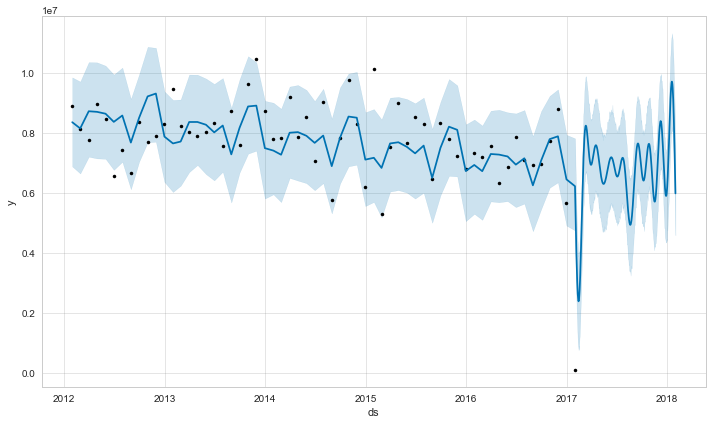

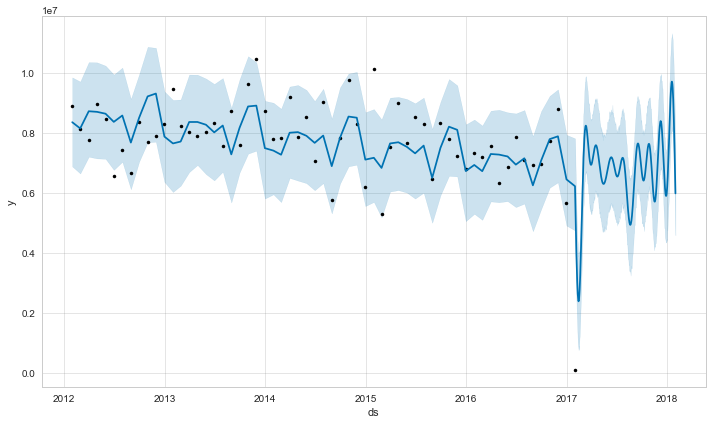

In [204]:
#Plotting the forecasted data
m.plot(forecast)

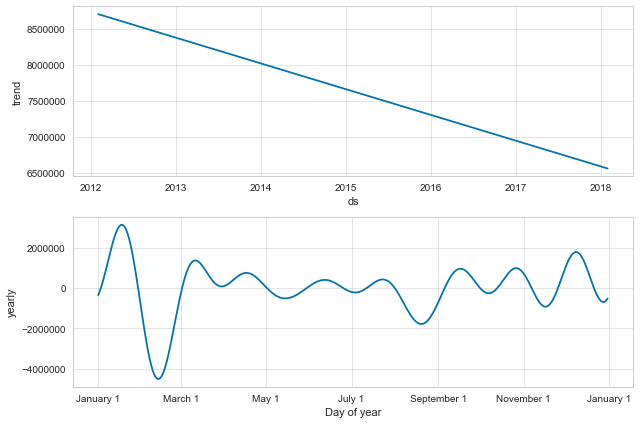

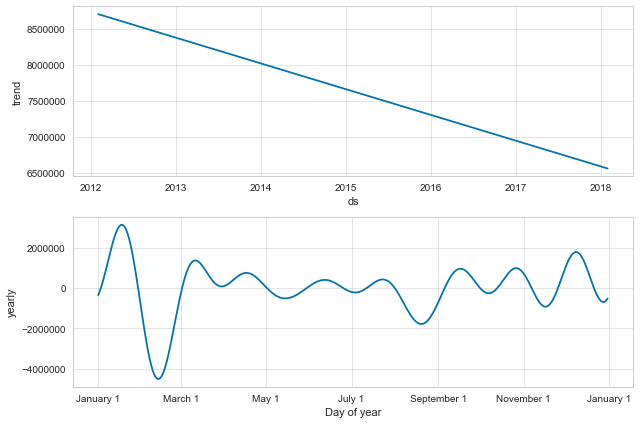

In [205]:
#taking a look at the seasonality and trend components of our /data/model/forecast.
m.plot_components(forecast)

In [175]:
forecast_data_orig = forecast # make sure we save the original forecast data
forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])

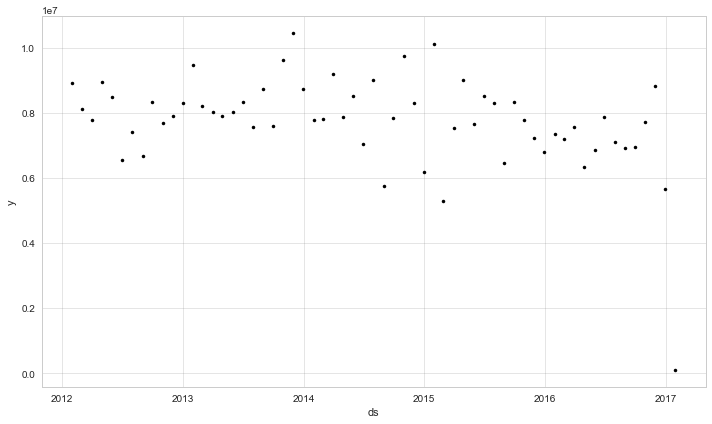

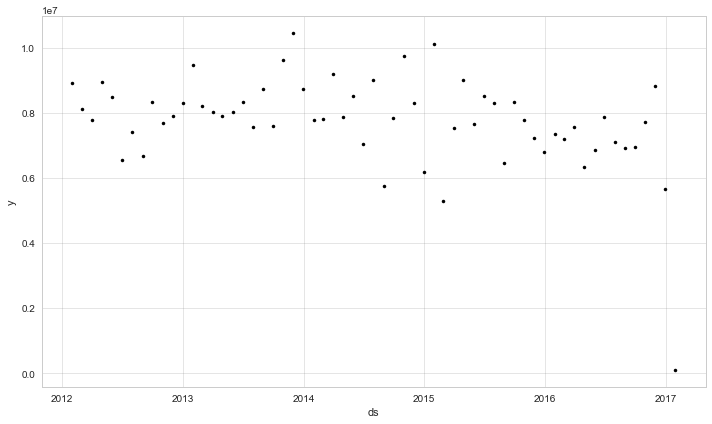

In [176]:
m.plot(forecast_data_orig)

In [190]:
combine_df = fin_df.join(forecast_data[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

In [191]:
combine_df.head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2012-01-31,8911000.0,8.358097e+06,6.858346e+06,9.954613e+06
1,2012-02-29,8131000.0,8.150958e+06,6.535704e+06,9.810300e+06
2,2012-03-31,7775000.0,8.723891e+06,7.196548e+06,1.025925e+07
3,2012-04-30,8960000.0,8.703554e+06,7.201588e+06,1.032974e+07
4,2012-05-31,8475000.0,8.641767e+06,7.055447e+06,1.020402e+07


It can be seen from the forecast that the product 1359 has been an increase in demand for the product over the years, from 2012 to 2018